# <center>Online Retail Clustering</center>

### Agenda : 
We are required to cluster the customers using different attributes shared in the data
### Data used : 
We have used the data to define the frequency of purchase, recency of purchase and amount of purchase to cluster the customers

### This notebook has been created after multiple iteration:<br>
1. Iteration 1 : Implemented the K means algorithm using python
2. Iteration 2 : Created other data attributes which may help in Clustering
3. Iteration 3 : Scaled the data to improve the clustering technique
4. Iteration 4 : Lastly, realised there are anomalies and so implemented IQR to eliminate iteration


## Importing libraries

In [313]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

## Reading dataframe

In [314]:
# Pulling invoice data
df_retail = pd.read_csv(r'C:\Users\Prashant\Documents\Machine Learing Workspace\Online-Retail-Clustering\.gitignore\OnlineRetail.csv')

In [315]:
df_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


## Null value treatment

In [316]:
df_retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [317]:
print('Number of na in customer id =' ,df_retail['CustomerID'].isna().sum())
print('Number of null in customer id =' ,df_retail['CustomerID'].isnull().sum())

Number of na in customer id = 135080
Number of null in customer id = 135080


In [318]:
df_retail.dropna(inplace=True)
df_retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


## Creating attributes for clustering

In [319]:
# First attribute : Total amount paid
df_retail['Amount'] = df_retail['Quantity'] * df_retail['UnitPrice']
df_amount = df_retail.groupby(['CustomerID'],as_index=False)["Amount"].sum()
df_amount.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [320]:
# Second attribute : Purchase recency

# UDF to convert string to datetime
def convertDate(x):
    conv_date = datetime.datetime.strptime(x, '%d-%m-%Y %H:%M')
    return conv_date

In [321]:
# UDF to split date and pick out recent purchase days 
def splitDate(y):
    y = str(y)
    num_days = y.split()[0]
    num_days = int(num_days)
    return num_days

In [322]:
df_retail['InvoiceDate'] = df_retail.loc[:,'InvoiceDate'].apply(convertDate)

In [323]:
max_date = df_retail['InvoiceDate'].max()
df_retail['Recent_purchase_days'] = max_date - df_retail['InvoiceDate']

In [324]:
df_retail['Recent_purchase_days'] = df_retail['Recent_purchase_days'].apply(splitDate)
df_rec_purch = df_retail.groupby(['CustomerID'],as_index=False)["Recent_purchase_days"].min()
df_rec_purch.head()

,CustomerID,Recent_purchase_days
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [325]:
# Attribute : Frequency of purchase
df_purchase_freq = df_retail.groupby(['CustomerID'],as_index=False)["InvoiceNo"].count()
df_purchase_freq.rename(columns={'CustomerID':'CustomerID','InvoiceNo':'PurchaseCount'},inplace=True)
df_purchase_freq.head()

,CustomerID,PurchaseCount
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


## Create Analytical data set for the clustering model

In [326]:
df_amt_purch = df_amount.merge(df_rec_purch,how='left',on=['CustomerID'])
df_model_inp = df_amt_purch.merge(df_purchase_freq,how='left',on=['CustomerID'])
df_model_inp.head()

,CustomerID,Amount,Recent_purchase_days,PurchaseCount
0,12346.0,0.00,325,2
1,12347.0,4310.00,1,182
2,12348.0,1797.24,74,31
3,12349.0,1757.55,18,73
4,12350.0,334.40,309,17


## Anomaly detection

In [327]:
# UDF to determine outliers in data for all the columns
def viewDistribution(df):
    sns.boxplot(data=df)
    plt.xticks(rotation=90)
    plt.show

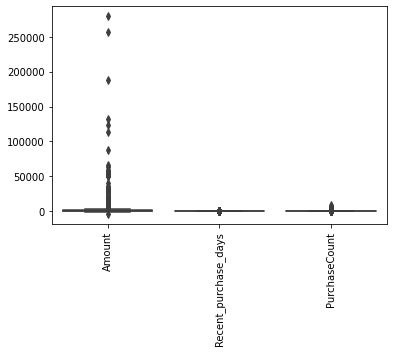

In [328]:
# INSIGHTS: There are outliers in amount and frequency column
df_anomaly = df_model_inp.iloc[:,1:4]
viewDistribution(df_anomaly)

In [329]:
# UDF to remove outlier
def remove_outlier_IQR(df):
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    df_final=df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    return df_final

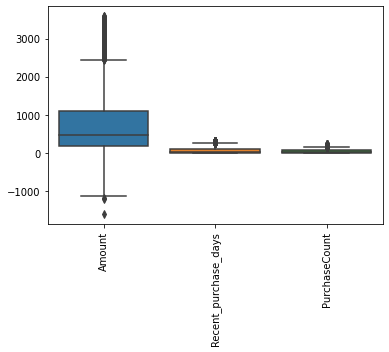

In [330]:
# Removed the anomalies in all the columns
df_IQR = remove_outlier_IQR(df_anomaly)
df_IQR.fillna(0,inplace=True)
viewDistribution(df_IQR)

## Performing scaling on the analytical data set

In [331]:
from sklearn.preprocessing import StandardScaler
# define standard scaler
scaler = StandardScaler()
# transform data
df_scalar = scaler.fit_transform(df_IQR)

df_scalar1 = pd.DataFrame(df_scalar)
df_scalar1.columns = ['Amount' , 'Frequency' , 'Recency']
df_scalar1.head()

,Amount,Frequency,Recency
0,-0.949212,2.786059,-0.919203
1,-0.949212,-0.880010,2.516333
2,1.259433,-0.054013,-0.365700
3,1.210658,-0.687655,0.435925
4,-0.538265,2.605019,-0.632909


## Mathematical implementation of K means clustering techinique
1.Pick K points as the initial centroids from the data set, either randomly or the first K.<br>
2.Find the Euclidean distance of each point in the data set with the identified K points — cluster centroids.<br>
3.Assign each data point to the closest centroid using the distance found in the previous step.<br>
4.Find the new centroid by taking the average of the points in each cluster group.<br>
5.Repeat iteration till the centroids don’t change.<br>


In [332]:
# Defining centroids
k = 5

# Filtering the columns required for clustering
data = df_IQR.iloc[:,0:3]
data.head()

,Amount,Recent_purchase_days,PurchaseCount
0,0.00,325.0,2.0
1,0.00,1.0,182.0
2,1797.24,74.0,31.0
3,1757.55,18.0,73.0
4,334.40,309.0,17.0


In [333]:
# Storing the sample dataframe to determine the number of centroids
k_means = (data.sample(k, replace=False))    # store current means
k_means2 = pd.DataFrame()                    # store previous means
clusters = pd.DataFrame()    

In [334]:
while not k_means2.equals(k_means):
    # distance matrix (euclidean distance)
    cluster_count = 0
    for idx, k_mean in k_means.iterrows():
        clusters[cluster_count] = (data[k_means.columns] - np.array(k_mean)).pow(2).sum(1).pow(0.5)
        cluster_count += 1

    # update cluster
    data['MDCluster'] = clusters.idxmin(axis=1)

    # store previous cluster
    k_means2 = k_means
    k_means = pd.DataFrame()
    k_means_frame = data.groupby('MDCluster').agg(np.mean)
    k_means[k_means_frame.columns] = k_means_frame[k_means_frame.columns]

ipykernel_launcher:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [335]:
data.head()

,Amount,Recent_purchase_days,PurchaseCount,MDCluster
0,0.00,325.0,2.0,1
1,0.00,1.0,182.0,1
2,1797.24,74.0,31.0,0
3,1757.55,18.0,73.0,0
4,334.40,309.0,17.0,1


## Plotting clusters 

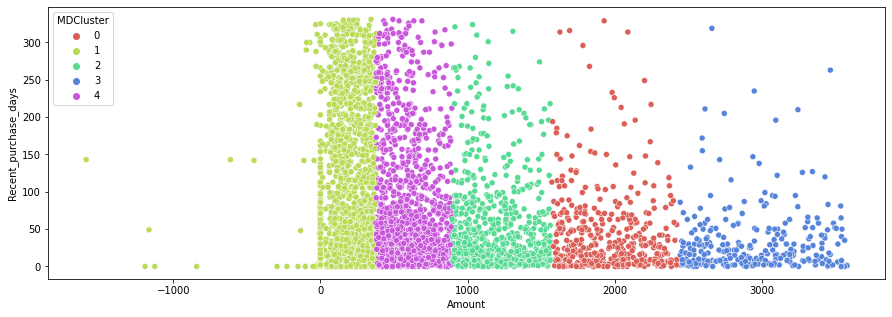

In [347]:
import seaborn as sns
plt.figure(figsize=(15,5))
sns.scatterplot(x=data['Amount'] ,y=data['Recent_purchase_days'] , hue = data['MDCluster'], palette = sns.color_palette('hls',5))
plt.show()

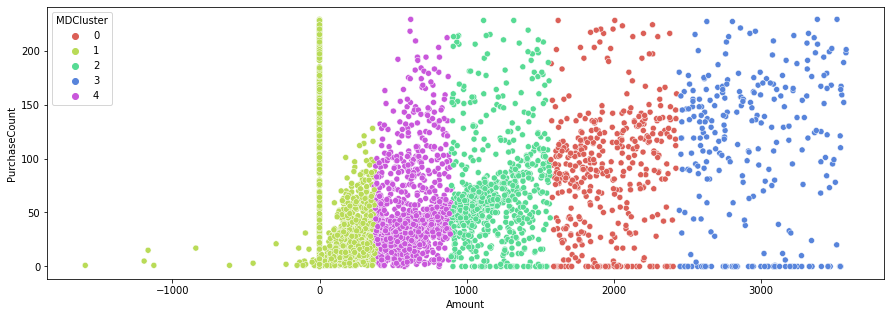

In [350]:
plt.figure(figsize=(15,5))
sns.scatterplot(x=data['Amount'] ,y=data['PurchaseCount'] , hue = data['MDCluster'], palette = sns.color_palette('hls',5))
plt.show()

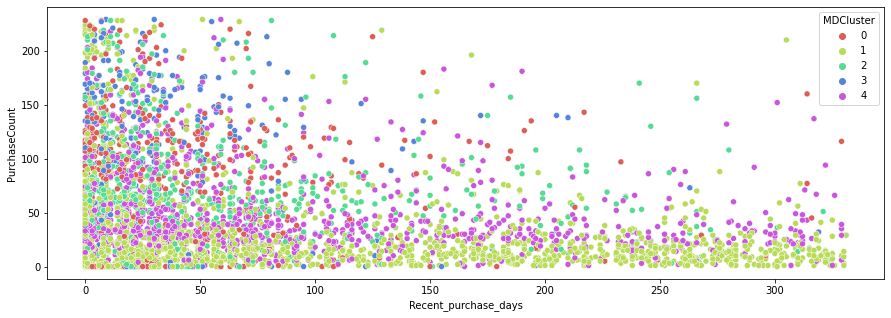

In [351]:
plt.figure(figsize=(15,5))
sns.scatterplot(x=data['Recent_purchase_days'] ,y=data['PurchaseCount'] , hue = data['MDCluster'], palette = sns.color_palette('hls',5))
plt.show()